In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
cancer_dir = pathlib.Path("data/unhealthy")
normal_dir = pathlib.Path("data/healthy")
classes = ['normal', 'cancer']
labels_dict = {'cancer': 1, 'normal': 0}

In [3]:
filepaths, labels = [], []
for dir_path, label in zip([normal_dir, cancer_dir], classes):
    for file in dir_path.glob("*"):
        filepaths.append(str(file))
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

labels
cancer    5504
normal    1008
Name: count, dtype: int64


C:\Users\vansh\AppData\Local\Temp\ipykernel_17724\584160856.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


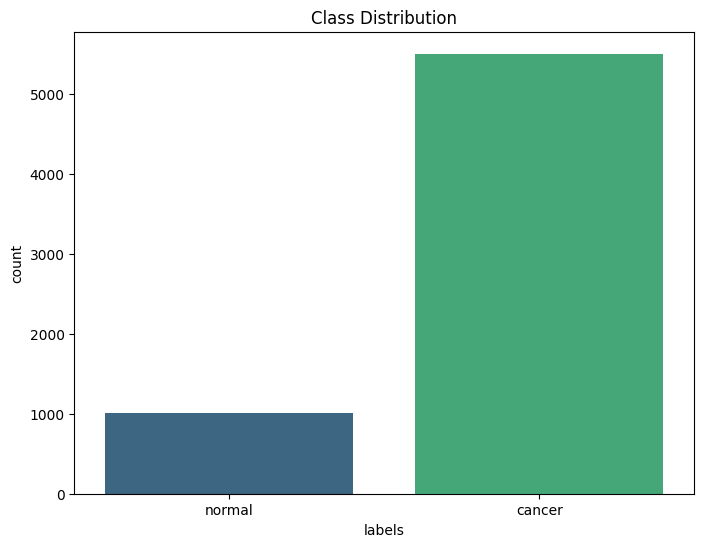

In [4]:
print(df['labels'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Class Distribution")
plt.show()

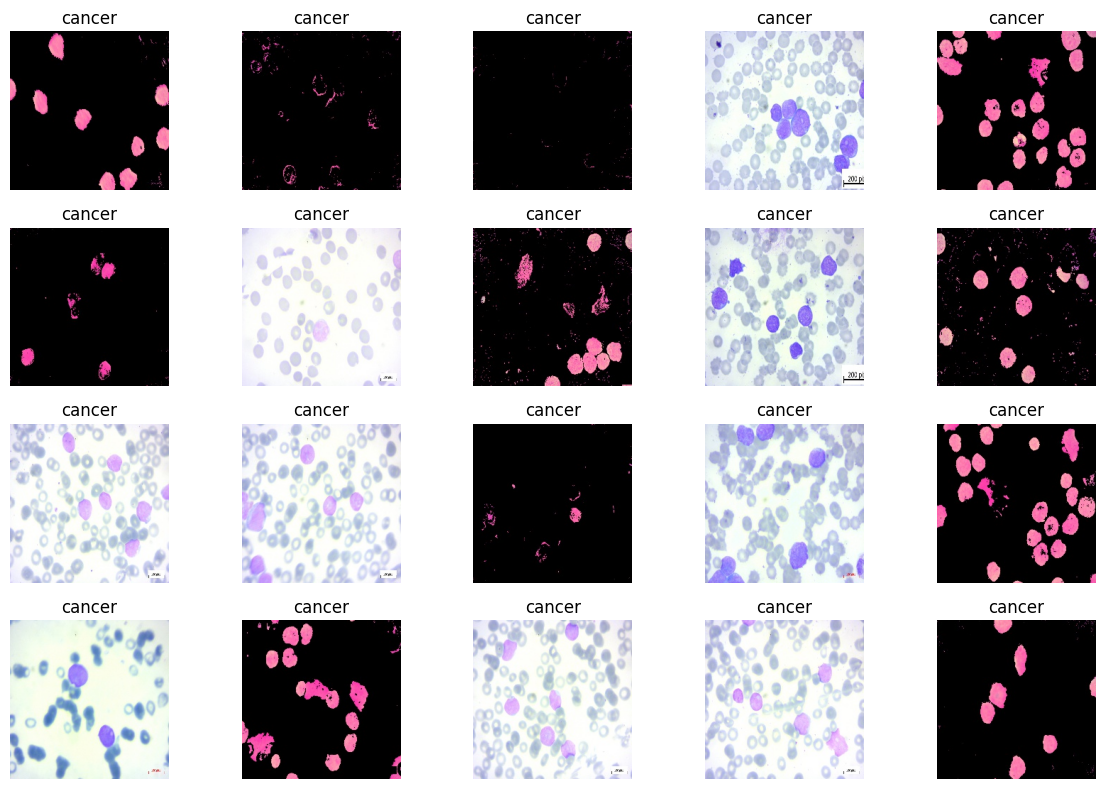

In [5]:
plt.figure(figsize=(12, 8))
for i in range(20):
    random_idx = np.random.randint(0, len(df))
    plt.subplot(4, 5, i + 1)
    img = cv2.imread(df.loc[random_idx, "filepaths"])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(df.loc[random_idx, "labels"])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [7]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=32, shuffle=True
)
val = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=32, shuffle=False
)
test = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=32, shuffle=False
)

Found 3646 validated image filenames belonging to 2 classes.
Found 912 validated image filenames belonging to 2 classes.
Found 1954 validated image filenames belonging to 2 classes.


In [8]:
def prepare_lstm_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X.append(X_batch)
        y.append(y_batch)
    X = np.vstack(X)
    y = np.vstack(y)
    X = X.reshape(X.shape[0], -1, 3) 
    return X, y

train_X, train_y = prepare_lstm_data(train)
val_X, val_y = prepare_lstm_data(val)

In [9]:
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Coding\Blood-Cancer-Detection\venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = bilstm_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10


In [ ]:
test_X, test_y = prepare_lstm_data(test)
test_loss, test_accuracy = bilstm_model.evaluate(test_X, test_y)
print(f"Test Accuracy: {test_accuracy:.2f}")

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_probs = bilstm_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

In [ ]:
predictions = np.argmax(bilstm_model.predict(test_X), axis=-1)
true_labels = np.argmax(test_y, axis=-1)

cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples', linecolor='black', linewidth=1)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
y_pred_probs = bilstm_model.predict(test_X)[:, 1]
fpr, tpr, _ = roc_curve(true_labels, y_pred_probs)
roc_auc = roc_auc_score(true_labels, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()